# Optimización de Parámetros - ARIMA (uno)

In [1]:
## Get current work directory to load all the custom modules
from pathlib import Path
import sys
BASE_DIR = Path().absolute().resolve(strict=True).parent.parent.parent
if str(BASE_DIR) not in sys.path:
    sys.path.append(str(BASE_DIR))

In [2]:
DATA_PATH = os.path.join(BASE_DIR, 'data', 'gruas')
print(DATA_PATH)

/workspace/Externos/TimeSeries/BenchMark/data/gruas


In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

In [4]:
import statsmodels.api as sm
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import optuna
import datetime

In [5]:
from helpers.general import  print_forecasting_results
from modulos.arima.gruas.general import format_timeseries, show_results_r2, arima_forecasting, total_forecasting, show_optimizer_results

In [6]:
data = pd.read_csv(os.path.join(DATA_PATH, 'producto.csv'), parse_dates=['Periodo'])
data.head()

,idArticulo,ventas,DescProducto,Periodo
0,tuerc,7,TUERCA,2021-05-01
1,tuerc,5,TUERCA,2020-12-01
2,tuerc,1,TUERCA,2020-11-01
3,tuerc,11,TUERCA,2020-09-01
4,tuerc,4,TUERCA,2020-06-01


In [7]:
data['Periodo'][0]

Timestamp('2021-05-01 00:00:00')

In [8]:
# Pivotando las tablas y llenando de ceros las ventas que no existen.
df_time = format_timeseries(data)
df_time.tail()

idArticulo,arandel,bateriascanrec,filtrodeair,filtrodepresio,filtroderetorn,pern,soport,tuerc
Periodo,,,,,,,,
2021-06-01,0.0,0.0,2.0,2.0,4.0,0.0,0.0,0.0
2021-07-01,0.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0
2021-08-01,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2021-09-01,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2021-10-01,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0


## Optimizando un solo Producto

## Baseline ARIMA

In [9]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 2016-04-01 to 2021-10-01
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   arandel         57 non-null     float64
 1   bateriascanrec  57 non-null     float64
 2   filtrodeair     57 non-null     float64
 3   filtrodepresio  57 non-null     float64
 4   filtroderetorn  57 non-null     float64
 5   pern            57 non-null     float64
 6   soport          57 non-null     float64
 7   tuerc           57 non-null     float64
dtypes: float64(8)
memory usage: 4.0 KB


In [10]:
   
idArticulo = 'filtrodeair'
result = total_forecasting(df_time[[idArticulo]])
    

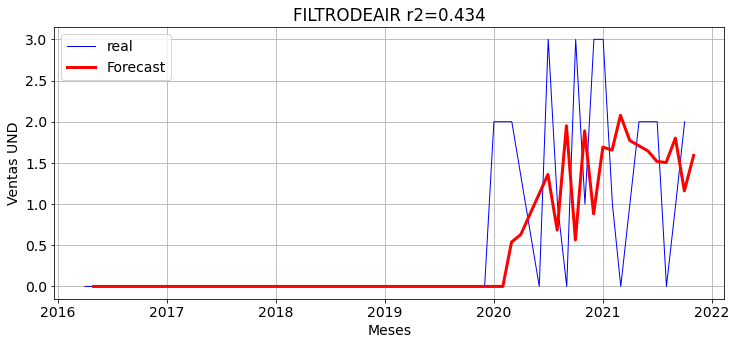

0.433739476546548

In [11]:
    
show_results_r2(df_time, result, idArticulo)

# Optimización por [OPTUNA](https://github.com/optuna/optuna/blob/40b097650d312913989b5825aa9c9adf4b15c396/docs/source/index.rst)

In [12]:
# You can increase iteration number.
iteration = 200

optuna.logging.disable_default_handler() # not display log
#optuna.logging.enable_default_handler() # display log

In [13]:

%%time

def objective(trial):
    r_min = 0
    r_max = 6
    ar = trial.suggest_int('ar', r_min, r_max)
    ii = trial.suggest_int('ii', r_min, r_max)
    ma = trial.suggest_int('ma', r_min, r_max)
    idArticulo = 'filtrodeair'
    pred = total_forecasting(df_time[[idArticulo]], ar, ii, ma)
    score = r2_score(df_time[idArticulo], pred.apply(lambda x: round(x,0)) )
    return score
SEED=5050

#study = optuna.create_study(direction='maximize')
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=iteration)

/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dave-linux/.local/lib/python3.8/site-pac

In [ ]:
study.best_value

0.6360887096774194

In [ ]:
study.best_params

{'ar': 5, 'ii': 2, 'ma': 5}

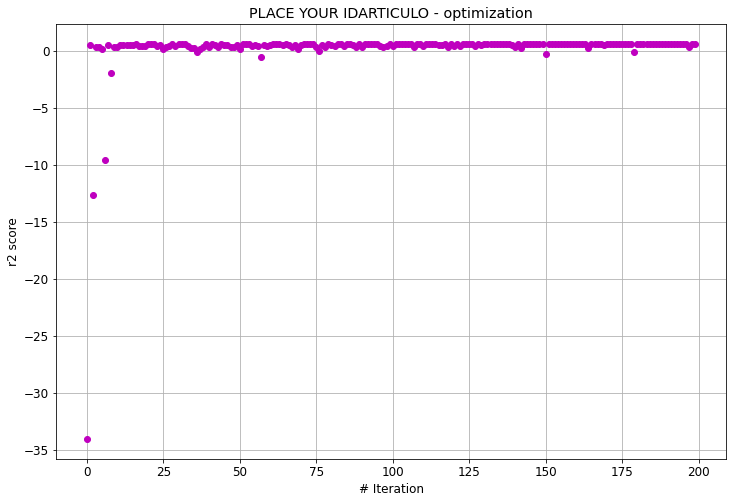

In [ ]:
show_optimizer_results([trial.value for trial in study.trials])

In [ ]:
idArticulo = 'filtrodeair'
# {'ar': 7, 'ii': 1, 'ma': 10} 
result = arima_forecasting(df_time[[idArticulo]],  **study.best_params)

/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dave-linux/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


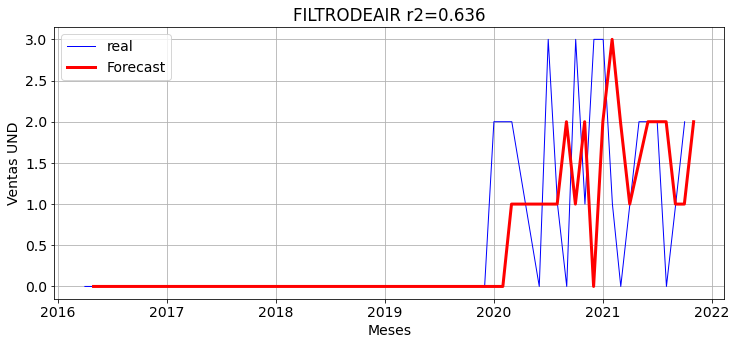

In [ ]:
r2 = show_results_r2(df_time, result.fittedvalues. apply(lambda x: round(x,0)), idArticulo)

In [ ]:
results = pd.DataFrame()
row = {'idArticulo':idArticulo, 'hyper':study.best_params, 'r2':r2 , 'model': 'ARIMA'}
results = results.append(row, ignore_index=True)
results.head()
results.to_csv(os.path.join(DATA_PATH, 'result', 'arima', 'arima_one.csv'), index=False)